In [33]:
import matplotlib
#matplotlib.use("TkAgg")
from scipy.io import wavfile
from scipy import signal
from scipy.signal import blackman
#from matplotlib import mlab
from matplotlib import pyplot as plt
import numpy as np
#from numpy.lib import stride_tricks
from pylab import *
from struct import pack
#import pywt
from scipy.fftpack import dct
#from struct import pack
import wave
from scipy.io import wavfile
import os
#import glob

import gc
import multiprocessing as mp
import resource 
import csv
import itertools

import pandas as pd
import ipywidgets as widgets

gc.enable()

flag = 0
date = '20211112'#'20210401'
data_path = 'data/'
mono_path = data_path + "wav/"
stereo_path = data_path + "stereo/"

mono_file_path = mono_path + date + "/"
stereo_file_path = stereo_path + date + "/"

sweep_path = data_path + "sweep/"
sweep_time_path = sweep_path + date + "/"

aud_path = data_path + "aud_times/"
aud_time_path = aud_path + date + "/"

visual_path = 'visual/'

#print os.path.splitext("20171025/data/")[0]

In [34]:
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:75% !important; }</style>"))

%config IPCompleter.greedy=True

In [35]:
def mem():
    print('Memory usage  : %2.2f MB' %round(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0,1))

In [40]:
mem()

Memory usage  : 228.60 MB


In [39]:
if not os.path.exists(stereo_file_path):
    os.mkdir(stereo_file_path,0o777)

for filename in os.listdir(mono_file_path):
    print (filename)
    samplerate, data = wavfile.read(mono_file_path + filename)
    rate = samplerate
    samples = len(data) 
    
    data_l = data.reshape(int(samples/2),2)[::2]
    data_r = data.reshape(int(samples/2),2)[1::2]
    
    wv = wave.open(stereo_file_path + filename,'w')
    wv.setparams((2, 2, rate, 0, 'NONE', 'Uncompressed'))
    
    wvData = np.hstack((data_l.reshape(-1, 1), data_r.reshape(-1,1)))
    
    wv.writeframes(wvData)
    wv.close()
    gc.collect()
    
print ('All wav files have been converted to dual channel stereo')

20211112_200036_805.wav
20211112_184744_338.wav
20211112_175136_959.wav
20211112_172653_021.wav
20211112_185114_715.wav
20211112_175144_479.wav
20211112_184628_022.wav
20211112_184701_935.wav
20211112_184609_930.wav
20211112_184617_452.wav
20211112_184654_419.wav
20211112_175153_694.wav
20211112_200138_959.wav
20211112_184736_836.wav
20211112_200109_838.wav
20211112_185040_839.wav
20211112_184754_336.wav
20211112_185143_823.wav
20211112_184710_415.wav
All wav files have been converted to dual channel stereo


In [41]:
gc.collect()

0

In [43]:
sessions = []
f = open(data_path + "capture_time.txt")
for rows in f.read().splitlines():
    sessions.append(rows.split('-'))
    
f.close()

In [44]:
session_list = []
line_no = 0
for row in sessions:
    if row[0] != '' and row[1] != '':
        starttime = datetime.datetime.strptime(row[0],'%Y/%m/%d %H:%M:%S.%f')
        endtime = datetime.datetime.strptime(row[1],'%Y/%m/%d %H:%M:%S.%f')
    #print starttime
    if starttime.date() == datetime.datetime.strptime(date,'%Y%m%d').date() : #Check if sessions available which matches the experiment date
        line_no = line_no + 1
        print ("(", line_no, ")", "\t", starttime, "-", endtime)
        #session_list.append(row[0] + "-" + row[1])
        session_list.append([starttime,endtime])
        
#print ("Plese register", str(ex[0]))
print ("Please input the session numbers. Separate them with commas. Confirm the start and end times using the experiment note.")
session = input("Session ") 
print ("You have chosen the sessions ", session)
#session = list(map(int, session))
#selected_session = session_list[int(session)-1]

( 1 ) 	 2021-11-12 17:51:36.922000 - 2021-11-12 17:51:53.668000
( 2 ) 	 2021-11-12 18:46:09.867000 - 2021-11-12 18:46:27.976000
( 3 ) 	 2021-11-12 18:46:54.170000 - 2021-11-12 18:47:10.353000
( 4 ) 	 2021-11-12 18:47:36.599000 - 2021-11-12 18:47:54.273000
( 5 ) 	 2021-11-12 18:50:23.839000 - 2021-11-12 18:50:40.747000
( 6 ) 	 2021-11-12 18:50:57.707000 - 2021-11-12 18:51:14.626000
( 7 ) 	 2021-11-12 18:51:27.261000 - 2021-11-12 18:51:43.777000
( 8 ) 	 2021-11-12 20:00:20.311000 - 2021-11-12 20:00:36.736000
( 9 ) 	 2021-11-12 20:00:53.071000 - 2021-11-12 20:01:09.782000
( 10 ) 	 2021-11-12 20:01:22.512000 - 2021-11-12 20:01:38.914000
Please input the session numbers. Separate them with commas. Confirm the start and end times using the experiment note.
Session 5
You have chosen the sessions  5


In [45]:
session = session.split(",")

session = list(map(int,session))

selected_session =[]
for s in session:
    selected_session.append(session_list[s-1])

In [46]:
selected_session

[[datetime.datetime(2021, 11, 12, 18, 50, 23, 839000),
  datetime.datetime(2021, 11, 12, 18, 50, 40, 747000)]]

In [47]:
def wav_list_maker():
    file_list = []
    for s in selected_session:
        for filename in os.listdir(stereo_file_path):
            t = filename.split('.')[0]
            filetime = datetime.datetime.strptime(t,'%Y%m%d_%H%M%S_%f')
            if filetime >= s[0]- datetime.timedelta(seconds=1) and filetime <= s[1] + datetime.timedelta(seconds=1):#add seconds occationally
                file_list.append(filename)
    return file_list

In [50]:
wav_filelist = wav_list_maker()
wav_filelist.sort()

In [51]:
wav_filelist

['20211112_185040_839.wav']

In [52]:
data_left = []
data_right = []

for audio_file in wav_filelist:#os.listdir(stereo_file_path):
    #audio_file = "20210906_171503_622.wav"
    #print(audio_file)
    #samplerate, data = wavfile.read('20171025/data/' + filename)
    audio_name = os.path.splitext(audio_file)[0]
    
     
    samplerate, data = wavfile.read(stereo_file_path + audio_file)

    data_left.extend(data[:, 0])
    data_right.extend(data[:, 1])
    #break
data_left = np.array(data_left)
data_right = np.array(data_right)

In [53]:
# Bandpass filter

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_signal(sweep_signal):
    #filtered_sweep_signals = []
    #print sweep_signals
    #for sig in sweep_signals:
    filtered_sweep_signals = butter_bandpass_filter(sweep_signal,17000,22000,samplerate)
    return filtered_sweep_signals

In [54]:
def visualize_fft(data):
    times = np.arange(len(data))/float(samplerate)

    plt.close("all")

    Fs = 192000#5000*2.#10000.
    NFFT = 4096#int(16384/2)#min(4096, len(data))#32768
    noverlap = NFFT - NFFT/10#NFFT /2 #fft size
    pad_to = NFFT * 16
    dynamicRange = 30#30 #change this to change the color scale. 
    vmin = 20*np.log10(np.max(data)) - dynamicRange

    #window=blackman(NFFT)
    #window=signal.nuttall(NFFT)
    #window=np.hamming(NFFT)
    window = np.hanning(NFFT)

    cmap = plt.get_cmap('magma')

    vmin = data_right.min()
    vmax = data_right.max()

    Pxx, freqs, times, cax = plt.specgram(data, NFFT=NFFT, window=window,vmin=-50, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', pad_to=pad_to, cmap=cmap)
    #print(len(Pxx))
    #Pxx_left, freqs_left, times_left, cax_left = plt.specgram(data_left, NFFT=NFFT, window=window, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', vmin=75, pad_to=pad_to, cmap=cmap)
    #Pxx_right, freqs_right, times_right, cax_right = plt.specgram(data_right, NFFT=NFFT, window=window, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', vmin=75, pad_to=pad_to, cmap=cmap)
    #Pxx = np.absolute(np.subtract(Pxx_left,Pxx_left))
    #print Pxx
    #f, t, Sxx = signal.spectrogram(data_right, Fs)

    #print type(Pxx)
    #plt.figure(figsize=(20,10))
    #plt.figure(figsize=(20,10))
    axes_spec = plt.gca()
    #axes_spec.set_xlim([2.8, 7.5])
    axes_spec.set_ylim([17000, 22000])#18500])

    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    #plt.pcolormesh(t, f, Sxx, vmax = 1e-6)
    #plt.show()

    plt.colorbar(cax, label='(dB)').ax.yaxis.set_label_position('left')

    plt.tight_layout()
    plt.show()
    #plt.savefig('swave_sweep.png',dpi=600)
    return Pxx, freqs, times

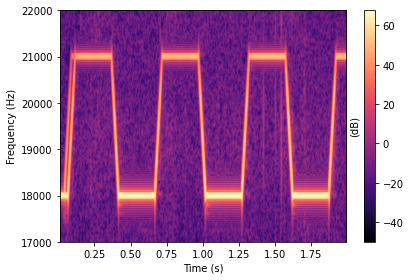

In [140]:
selected_data = data_right[int(3.3*192000):int(5.3*192000)]
Pxx,freqs,times = visualize_fft(selected_data)

In [141]:
df_pxx = pd.DataFrame(Pxx, index = freqs)

diff_pxx_1 = df_pxx.loc[17500:21500].diff(axis=1)
diff_pxx_0 = df_pxx.loc[17500:21500].diff(axis=0)

#normalize
diff_pxx_1=(diff_pxx_1-diff_pxx_1.min())/(diff_pxx_1.max()-diff_pxx_1.min())
diff_pxx_0=(diff_pxx_0-diff_pxx_0.min())/(diff_pxx_0.max()-diff_pxx_0.min())

df = diff_pxx_0.idxmax()#pd.DataFrame(Pxx).max()
normalized_df=(df-df.min())/(df.max()-df.min())

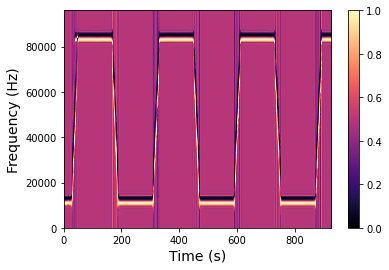

In [142]:
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Frequency (Hz)", fontsize=14)
plt.imshow(diff_pxx_0,cmap='magma',interpolation='nearest',origin='lower',extent=[df_pxx.diff().columns.values[0],df_pxx.diff().columns.values[-1],df_pxx.diff().index.values[0],df_pxx.diff().index.values[-1]], aspect='auto')
plt.colorbar()

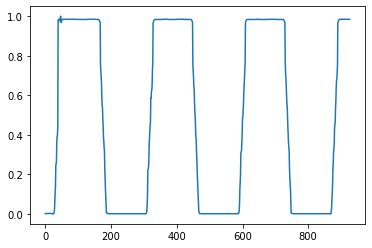

In [143]:
plt.plot(normalized_df)

In [144]:
def design_comp_wave(u,x,y,z):
    des_sweep = np.concatenate((np.full(u,1),np.arange(0.000001,1,1/x)[::-1],np.full(u,0),np.arange(0.000001,1,1/y),np.full(u,1),np.arange(0.000001,1,1/z)[::-1],np.full(u,0)))
    return des_sweep


In [145]:
def normalize_data(data):
    norm_data = data/np.max(data)
    return norm_data

def detect_segments(data):
    data = normalize_data(data)
    

# Parallelization

In [146]:
len(os.sched_getaffinity(0))

32

In [151]:
import multiprocessing
import pandas as pd

import time
start_time = time.time()


def f(nor_df):
    #corr_list = []
    for u in range(114,122):
        for x in range(20,25):
            for y in range(20,25):
                for z in range(20,25):
                    designed_signal = design_comp_wave(u,x,y,z)
                    corr_list = []
                    #if(len(normalized_df[i:len(normalized_df)])>len(normalized_df[i:select_len*(p+1)])):
                    #    nor_df = normalized_df[i:select_len*(p+1)]
                    #else:
                    #    nor_df = normalized_df[i:len(normalized_df)]
                    #normalized_df = normalized_df[:int(len(designed_signal)/2)]
                    nor_df = normalize_data(nor_df)
                    for j in range(len(designed_signal)):
                        if (len(designed_signal)>=len(nor_df)+j):
                            selected_seg = designed_signal[j:len(nor_df)+j]
                            #corr,_ = pearsonr(nor_df,selected_seg)
                            #corr, _ = fastdtw(selected_seg,nor_df)
                            corr = distance.euclidean(selected_seg,nor_df)
                            corr_list.append(corr)
                            #print(corr)
                            #plt.plot(nor_df)
                            #plt.plot(selected_seg)
                            
    max_cor = np.argmin(corr_list)##np.argmax(corr_list)#
    #print(max_cor)
    segment = designed_signal[max_cor:len(nor_df)+max_cor]
    #plt.figure(figsize=(8,5))
    #plt.plot(nor_df)
    #plt.plot(segment)
    #plt.show()
    return segment



if __name__ == '__main__':
    # Create pool with 4 processors
    pool = multiprocessing.Pool(len(os.sched_getaffinity(0)))
    print("check")
    jobs = []
    #for group in data['some_group']:
    i = 0
    p = 0
    approx_sig = []   
    select_len = 90#int(len(designed_signal)/4)
    data = []
    while select_len*(p)<len(normalized_df):
        # Create asynchronous jobs that will be submitted once a processor is ready
        if(len(normalized_df[i:len(normalized_df)])>len(normalized_df[i:select_len*(p+1)])):
            nor_df = normalized_df[i:select_len*(p+1)]
        else:
            nor_df = normalized_df[i:len(normalized_df)]
        #normalized_df = normalized_df[:int(len(designed_signal)/2)]
        nor_df = normalize_data(nor_df)
        data.append(nor_df.values)#data[data.some_group == group]
        
        
        i = select_len*(p+1)
        p=p+1
        
    for seg in data:
        jobs.append(pool.apply_async(f, (seg, )))
#print(i)
    # Submit jobs
    approx_sig.extend(job.get() for job in jobs)
    
approx_sig = np.concatenate(approx_sig).ravel().tolist()
    
# Combine results
#approx_sig.extend(results)
print("--- %s seconds ---" % (time.time() - start_time))

check
--- 22.786664962768555 seconds ---


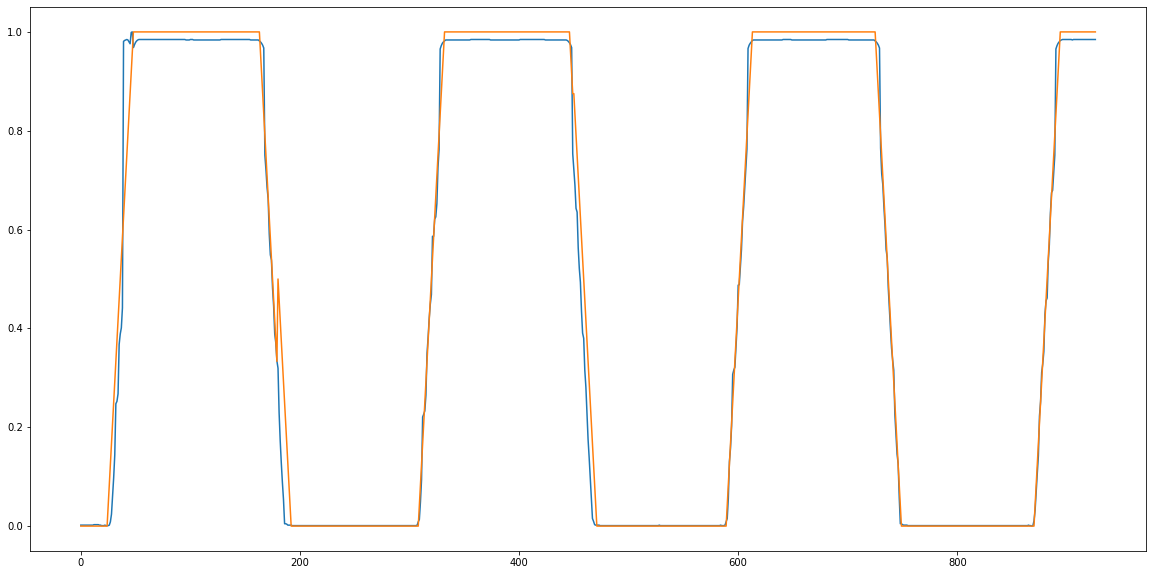

In [152]:
plt.figure(figsize=(20,10))
plt.plot(normalized_df)
plt.plot(approx_sig)

In [153]:
gc.collect()

29124

from fastdtw import fastdtw
from scipy.spatial import distance

import time
start_time = time.time()

i = 0
p = 0
approx_sig = []    


select_len = 90#int(len(designed_signal)/4)
while select_len*(p)<len(normalized_df):
    for u in range(114,122):
        for x in range(20,25):
            for y in range(20,25):
                for z in range(20,25):
                    designed_signal = design_comp_wave(u,x,y,z)
                    corr_list = []
                    if(len(normalized_df[i:len(normalized_df)])>len(normalized_df[i:select_len*(p+1)])):
                        nor_df = normalized_df[i:select_len*(p+1)]
                    else:
                        nor_df = normalized_df[i:len(normalized_df)]
                    #normalized_df = normalized_df[:int(len(designed_signal)/2)]
                    nor_df = normalize_data(nor_df)
                    for j in range(len(designed_signal)):
                        if (len(designed_signal)>=len(nor_df)+j):
                            selected_seg = designed_signal[j:len(nor_df)+j]
                            #corr,_ = pearsonr(nor_df,selected_seg)
                            #corr, _ = fastdtw(selected_seg,nor_df)
                            corr = distance.euclidean(selected_seg,nor_df)
                            corr_list.append(corr)
                            #print(corr)
                            #plt.plot(nor_df)
                            #plt.plot(selected_seg)
    i = select_len*(p+1)
    p=p+1
    #print(i)

    max_cor = np.argmin(corr_list)##np.argmax(corr_list)#
    #print(max_cor)
    segment = designed_signal[max_cor:len(nor_df)+max_cor]
    plt.figure(figsize=(8,5))
    plt.plot(nor_df.values)
    plt.plot(segment)
    approx_sig.extend(segment)
    #plt.plot()
    
print("--- %s seconds ---" % (time.time() - start_time))
    
gc.collect()

In [154]:
sine18 = []
s18 = []
sw = []
sweep =[]
s21 = []
sine21 = []
#approx_sig = smooth(approx_sig)
for x in range(len(approx_sig)):    
    #try:
    if(approx_sig[x]==0):
        s18.extend([x])
    else:
        if s18:
            sine18.append(s18)
        s18 = []
        
    if(approx_sig[x]>0 and approx_sig[x]<1):
        sw.extend([x])
    else:
        if sw:
            sweep.append(sw)
        sw = []
    
    if(approx_sig[x]==1):
        s21.extend([x])
    else:
        if s21:
            sine21.append(s21)
        s21 = []

In [155]:
for y in sine18:
    print(len(y))

24
115
117
120


In [156]:
for y in sweep:
    print(len(y))
    
sweep = [x for x in sweep if len(x)>20]

24
29
24
25
24
24
24


In [157]:
for y in sine21:
    print(len(y))

116
115
113


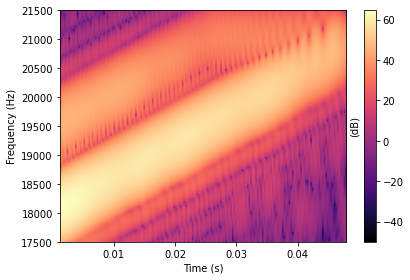

9430


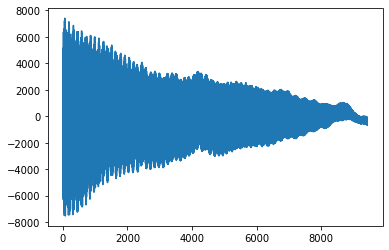

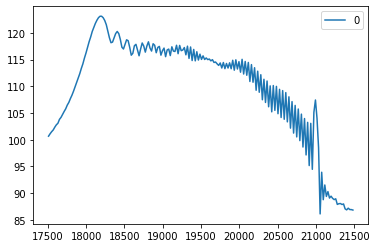

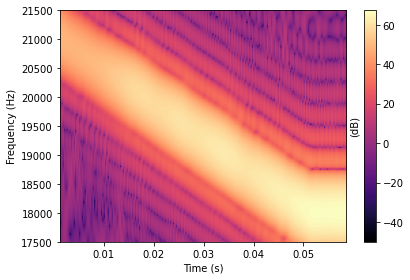

11480


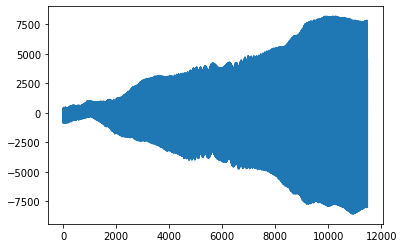

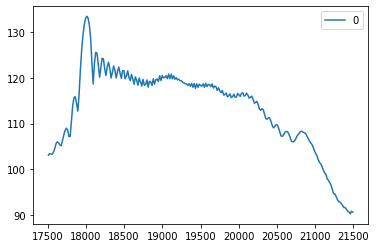

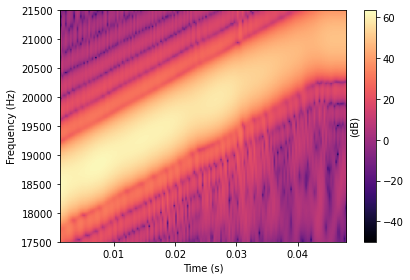

9430


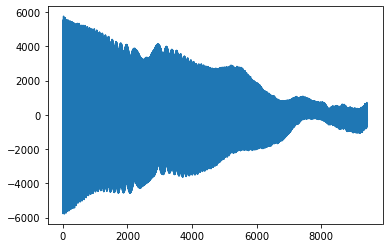

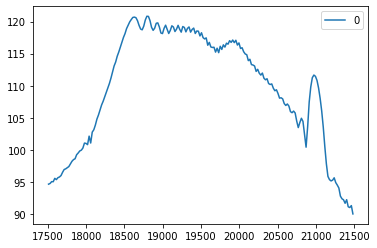

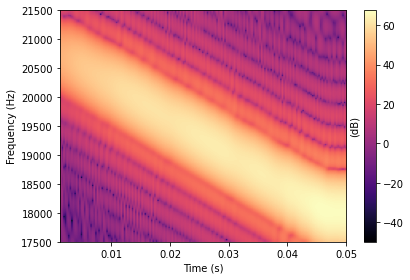

9840


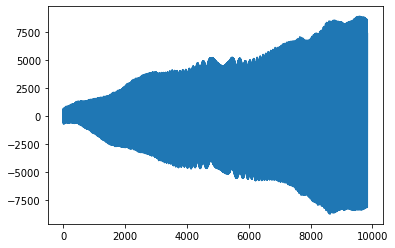

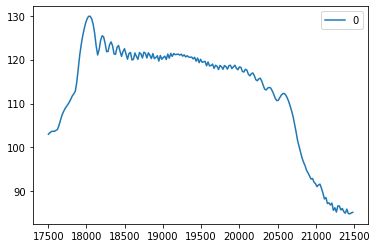

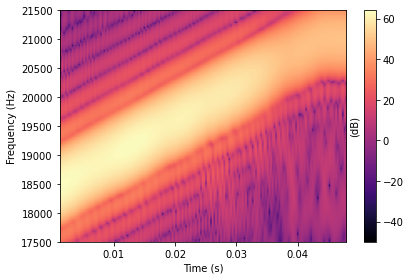

9430


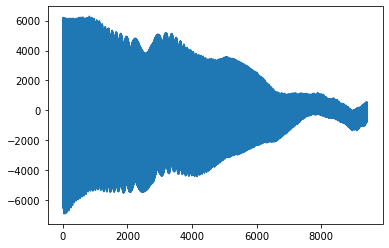

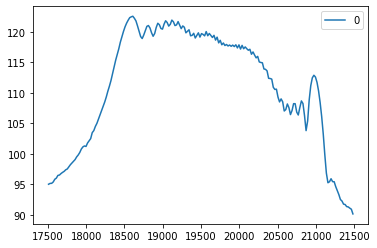

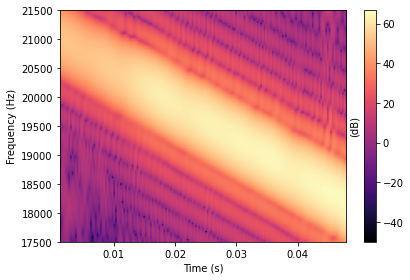

9430


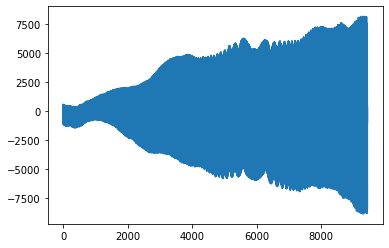

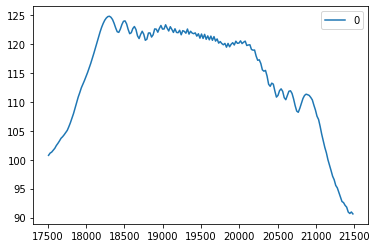

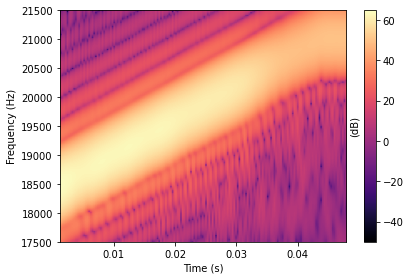

9430


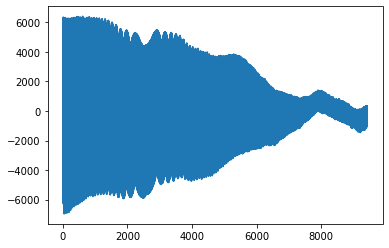

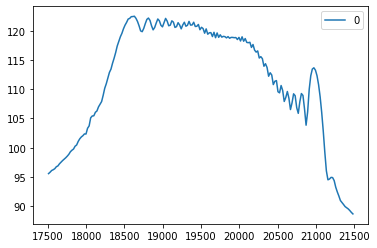

10295

In [159]:
for y in sweep:
    try:
        signal = selected_data[(y[0])*inverse_coef+int(4096*0.6)-1:(y[-1])*inverse_coef+int(4096*0.6)]
    except:
        signal = selected_data[(y[0])*inverse_coef+int(4096*0.4):(y[-1])*inverse_coef+int(4096*0.6)]
    _,_,_ = visualize_spec(signal,512,17500,21500,100)
    plt.plot(signal)
    print(len(signal))
    plt.show()
    calculate_spectrum(signal).T.plot()
    plt.show()
gc.collect()

In [69]:
import pylab as pl

def calculate_spectrum(signal):
    rate = samplerate
    t = np.arange(0, 10, 1/rate)
    x = signal
    p = 20*np.log10(np.abs(np.fft.rfft(x)))
    f = np.linspace(0, rate/2, len(p))
    #print(len(p))
    #print(len(f))
    #print(f)
    #plt.plot(p[500:750])
    spectrum = pd.DataFrame(p)
    spectrum.index = f
    #display(spectrum[18000:21000])
    #spectrum[18000:21000].plot()
    #plot(f[18000:21000], p[18000:21000])
    #plt.show()
    return spectrum[17500:21500].T

In [70]:
def visualize_spec(data,NFFT,low,high,dynamicRange):#,name,n):
    times = np.arange(len(data))/float(samplerate)

    plt.close("all")

    Fs = 192000#5000*2.#10000.
    NFFT = NFFT#int(16384/2)#min(4096, len(data))#32768
    noverlap = NFFT - NFFT/10#NFFT /2 #fft size
    pad_to = NFFT * 16
    dynamicRange = dynamicRange#30 #change this to change the color scale. 
    #vmin = 20*np.log10(np.max(data)) - dynamicRange

    #window=blackman(NFFT)
    #window=signal.nuttall(NFFT)
    #window=np.hamming(NFFT)
    window = np.hanning(NFFT)

    cmap = plt.get_cmap('magma')

    #vmin = data_right.min()
    #vmax = data_right.max()

    Pxx, freqs, times, cax = plt.specgram(data, NFFT=NFFT, window=window,vmin=-50, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', pad_to=pad_to, cmap=cmap)
    #print(len(Pxx))
    #Pxx_left, freqs_left, times_left, cax_left = plt.specgram(data_left, NFFT=NFFT, window=window, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', vmin=75, pad_to=pad_to, cmap=cmap)
    #Pxx_right, freqs_right, times_right, cax_right = plt.specgram(data_right, NFFT=NFFT, window=window, Fs=samplerate, noverlap=noverlap, mode='magnitude', scale='dB', vmin=75, pad_to=pad_to, cmap=cmap)
    #Pxx = np.absolute(np.subtract(Pxx_left,Pxx_left))
    #print Pxx
    #f, t, Sxx = signal.spectrogram(data_right, Fs)

    #print type(Pxx)
    #plt.figure(figsize=(20,10))
    #plt.figure(figsize=(20,10))
    axes_spec = plt.gca()
    #axes_spec.set_xlim([2.8, 7.5])
    axes_spec.set_ylim([low, high])#18500])

    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    #plt.pcolormesh(t, f, Sxx, vmax = 1e-6)
    #plt.show()

    plt.colorbar(cax, label='(dB)').ax.yaxis.set_label_position('left')

    plt.tight_layout()
    #plt.savefig("visual/20211021/us_bicycle_approaching/" + name + "_" +str(n)+".png")
    plt.show()
    return Pxx, freqs, times



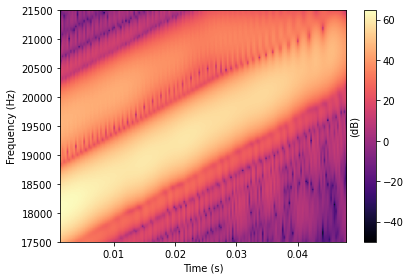

9430


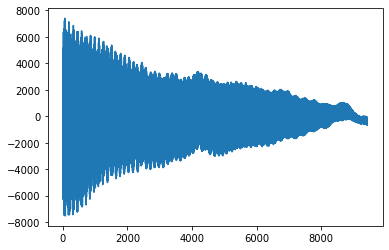

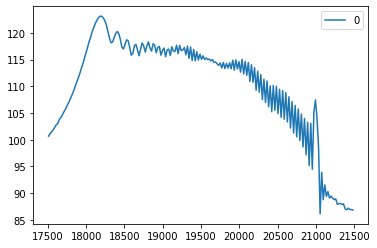

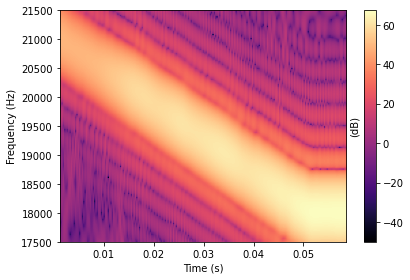

11480


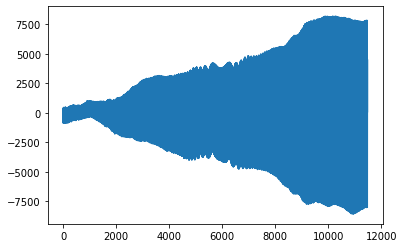

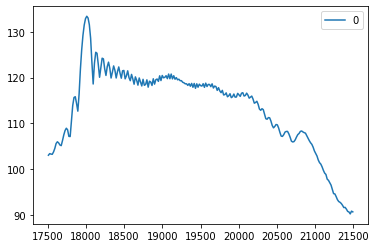

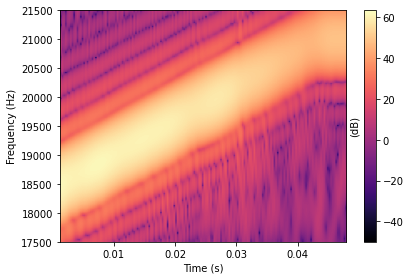

9430


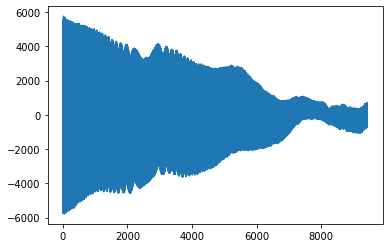

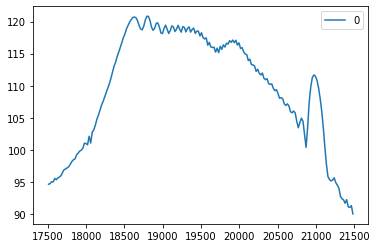

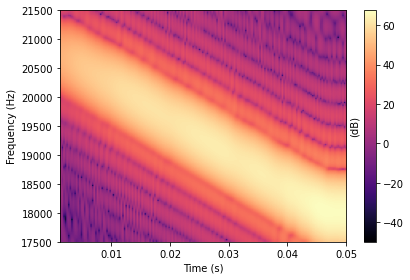

9840


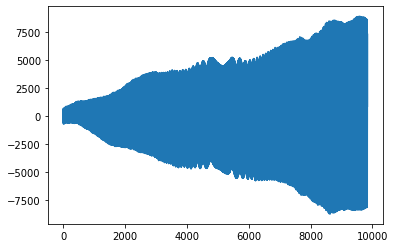

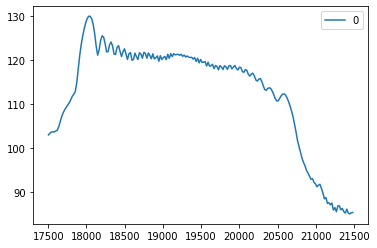

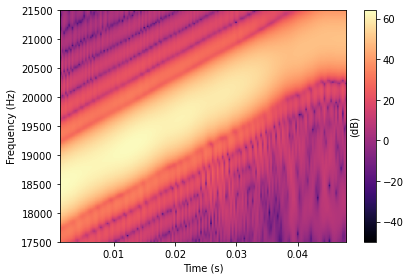

9430


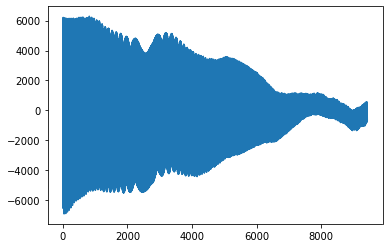

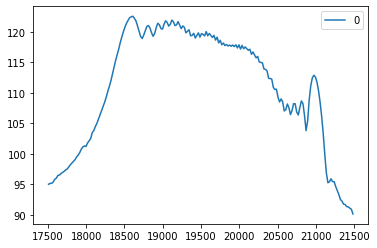

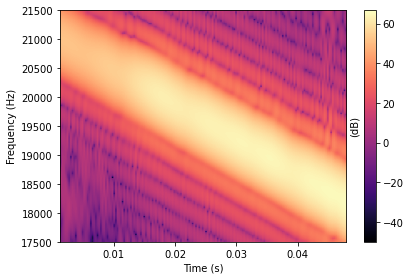

9430


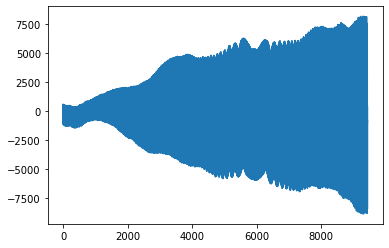

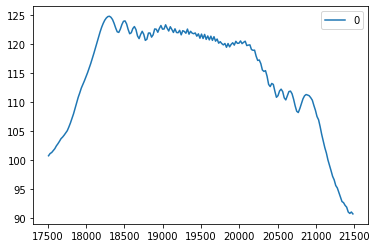

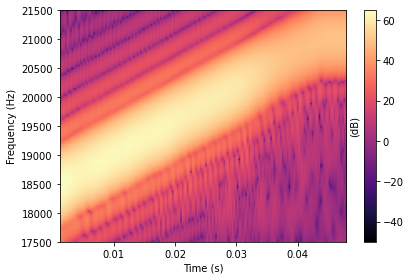

9430


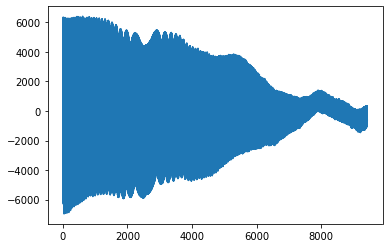

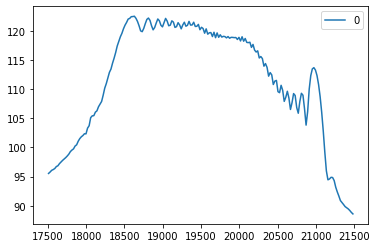

5679

In [72]:
inverse_coef = 410

for y in sweep:
    try:
        signal = selected_data[(y[0])*inverse_coef+int(4096*0.6):(y[-1])*inverse_coef+int(4096*0.6)]
    except:
        signal = selected_data[(y[0])*inverse_coef+int(4096*0.4):(y[-1])*inverse_coef+int(4096*0.6)]
    _,_,_ = visualize_spec(signal,512,17500,21500,100)
    plt.plot(signal)
    print(len(signal))
    plt.show()
    calculate_spectrum(signal).T.plot()
    plt.show()
gc.collect()

In [74]:
from scipy.signal import chirp

def generate_sweep():
    x = 0
    if samplerate == 96000:
        x = 9600
    if samplerate == 192000:
        x = 19200
    
    
    f1 = 18000        # start frequency
    f2 = 21000       # end frequency
    fs = samplerate#96000      # sampling frequency
    T = 0.05          # time duration of the sweep
    t = float(x)/samplerate

    a = (f2 - f1)/float(T)

    t = np.arange(0,np.round(fs*T-1)/fs,1/fs)  # time axis
    sweep = np.sin(2*np.pi*((a*t**2)/2 + (f1*t)))
    #s = np.sin(2*np.pi*f1*np.exp(t)) 
    return sweep

In [75]:
from scipy.signal import hilbert
def calc_envelop(cut):
    analytic_signal = hilbert(cut)
    amplitude_envelop = np.abs(analytic_signal)
    return amplitude_envelop

In [76]:
from scipy.stats import linregress
def determine_gradient(data):
    return linregress(np.arange(len(data)),data).slope

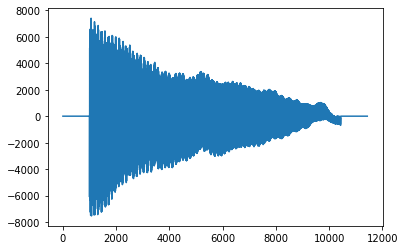

*** Sweep ***


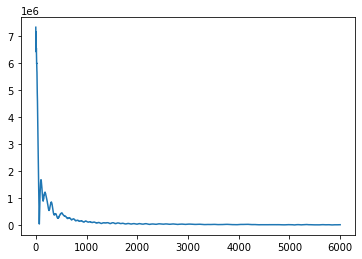

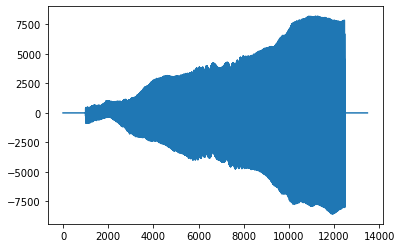

*** Inverse sweep ***


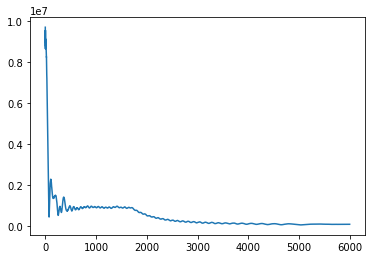

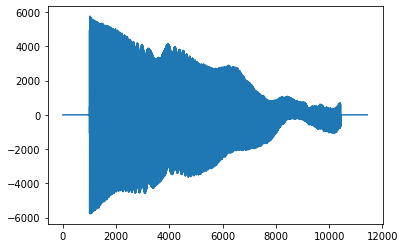

*** Sweep ***


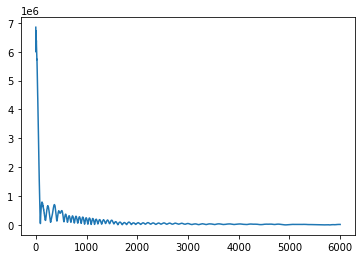

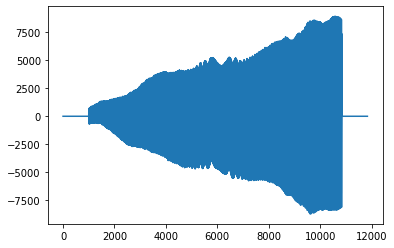

*** Inverse sweep ***


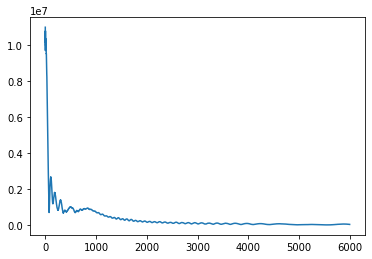

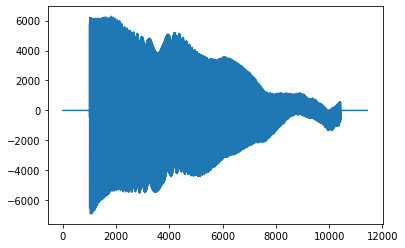

*** Sweep ***


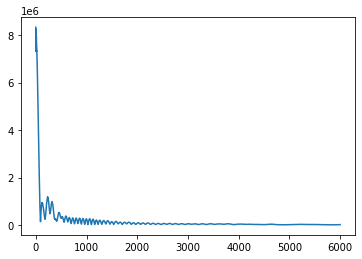

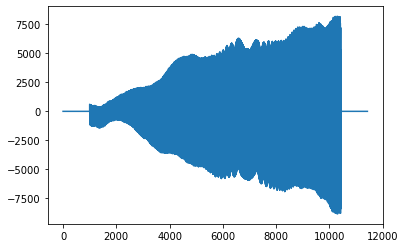

*** Inverse sweep ***


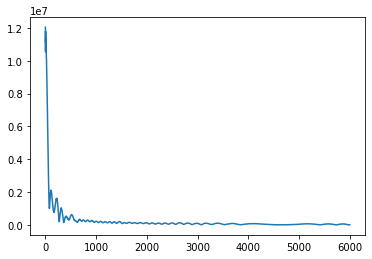

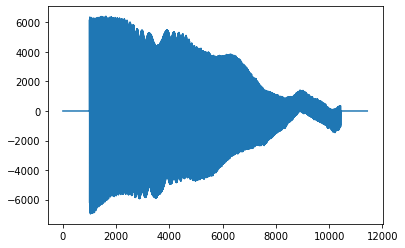

*** Sweep ***


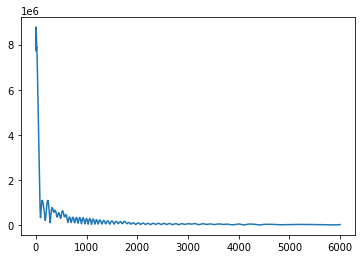

2623

In [77]:
generated_sweep = generate_sweep()
corr = []
corr_raw = []
n=0
name="sweep_IRs_"

#Change data to either data_left or data_right
#selected_data = data_left[int(3.3*192000):int(12.5*192000)]

for y in sweep:
    try:
        data = selected_data[(y[0])*inverse_coef+int(4096*0.6):(y[-1])*inverse_coef+int(4096*0.6)]
    except:
        data = selected_data[(y[0])*inverse_coef+int(4096*0.4):(y[-1])*inverse_coef+int(4096*0.6)]
        
    data = np.pad(data,(1000,1000),'constant')
    plt.plot(data)
    plt.show()
    #data = normalize_data(data)
    estimated_sig= approx_sig[y[0]:y[-1]]
    gradient = determine_gradient(estimated_sig)
    #_,_,_ = visualize_fft(data)
    if gradient>0:
        print("*** Sweep ***")
        #_,_,_ = visualize_spec(data,1024,17500,21500)
        conv = np.convolve(data,generated_sweep[::-1],'full')
    elif gradient<0:
        print("*** Inverse sweep ***")
        #_,_,_ = visualize_spec(data[::-1],1024,17500,21500)
        conv = np.convolve(data,generated_sweep,'full')
    conv_cut = conv[conv.argmax():]
    envelop = calc_envelop(conv_cut)
    plt.plot(envelop[:6000])
    #plt.savefig("visual/20211021/us_bicycle_approaching/" + name +str(n)+".png")
    plt.show()
    #envelop2 = get_envelop(conv_cut)
    corr_raw.append(conv_cut)
    corr.append(envelop)
    n=n+1
gc.collect()

In [78]:
nc_raw = []
nc = []
for i in corr_raw:
    nc_raw.append(i[:6000]/max(i[:6000]))
for i in corr:
    nc.append(i[:6000]/max(i[:6000]))

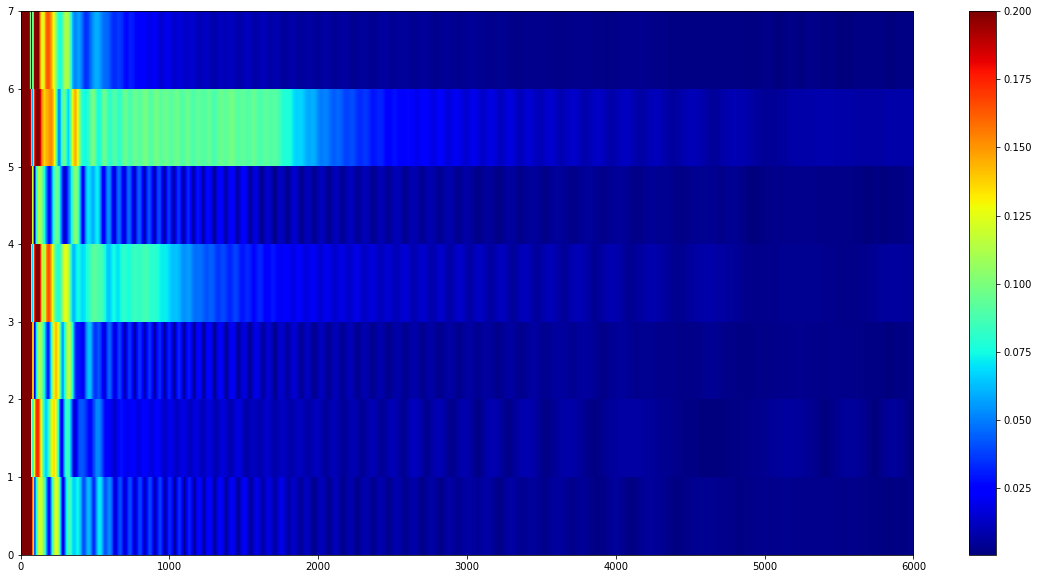

In [79]:
plt.figure(figsize=(20,10))
plt.imshow(pd.DataFrame(nc), vmax=0.2,cmap='jet', interpolation='nearest', origin='upper', extent=[0,len(nc[0]),0,len(nc)], aspect='auto')
plt.colorbar()